# Read Data and Setup Neural Net

In [109]:
import csv

from sklearn.neural_network import MLPRegressor

import numpy as np

from globus_setup import *

# CSV_NAME = "new_data.csv"
CSV_NAME = "values_normalized.csv"

print("reading data")
Xpred = []
X = []
y = []
with open(CSV_NAME, "r") as f:
    csv_reader = csv.DictReader(f)

    training_fields = set(csv_reader.fieldnames) - {"tas"}
    for row in csv_reader:
        # Remove rows which are missing values for any variable
        empty_fields = [f for f in row if row[f] == ""]
        if empty_fields:
            continue
        features = {k: float(v) for k, v in row.items() if k in training_fields}
        X.append(features)
        y.append(float(row["tas"]))


reading data


In [110]:
## Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
y_train = np.array(y_train, dtype=np.double)
y_test = np.array(y_test, dtype=np.double)
days_test = np.array([row["day"] for row in X_test], dtype=np.double)
days_train = np.array([row["day"] for row in X_train], dtype=np.double)
X_train = np.array([[v for k, v in row.items() if k != "day"] for row in X_train], dtype=np.double)
X_test = np.array([[v for k, v in row.items() if k != "day"] for row in X_test], dtype=np.double)


# Train Neural Net

In [114]:

clf = MLPRegressor(verbose=True, hidden_layer_sizes=[30]*10, tol=1e-10)
clf.fit(X_train, y_train)

Iteration 1, loss = 0.05876560
Iteration 2, loss = 0.01209276
Iteration 3, loss = 0.00228148
Iteration 4, loss = 0.00187322
Iteration 5, loss = 0.00175906
Iteration 6, loss = 0.00173379
Iteration 7, loss = 0.00160510
Iteration 8, loss = 0.00157158
Iteration 9, loss = 0.00156348
Iteration 10, loss = 0.00152534
Iteration 11, loss = 0.00151556
Iteration 12, loss = 0.00151192
Iteration 13, loss = 0.00147103
Iteration 14, loss = 0.00147376
Iteration 15, loss = 0.00143493
Iteration 16, loss = 0.00155809
Iteration 17, loss = 0.00149160
Iteration 18, loss = 0.00144971
Iteration 19, loss = 0.00140224
Iteration 20, loss = 0.00141572
Iteration 21, loss = 0.00147064
Iteration 22, loss = 0.00139856
Iteration 23, loss = 0.00144579
Iteration 24, loss = 0.00139688
Iteration 25, loss = 0.00135937
Iteration 26, loss = 0.00135499
Iteration 27, loss = 0.00135628
Iteration 28, loss = 0.00134424
Iteration 29, loss = 0.00136846
Iteration 30, loss = 0.00133962
Iteration 31, loss = 0.00130108
Iteration 32, los

c:\Users\mathe\Documents\Code\KU\Spring_22\EECS_738\Project\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=[30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
             tol=1e-10, verbose=True)

In [10]:
## Save model
import pickle
with open("model_cleaned_20_20_20.p", "wb") as f:
    pickle.dump(clf, f)

In [36]:
## Load model
import pickle
with open("model_original_20_20_20.p", "rb") as f:
    clf = pickle.load(f)

# Predict

In [115]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

y_pred = clf.predict(X_test)
print("r2_score: ", r2_score(y_test, y_pred))
print("explained_variance_score: ", explained_variance_score(y_test, y_pred))
print("mean_squared_error: ", mean_squared_error(y_test, y_pred))

r2_score:  0.9706821290422349
explained_variance_score:  0.9707390864872144
mean_squared_error:  0.0018319302321209044


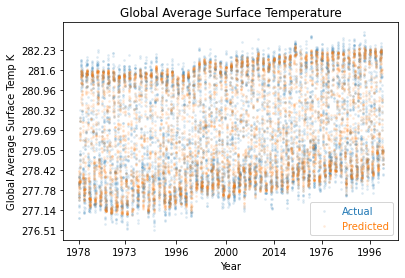

In [116]:
# Plot
from utilities import *

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(days_test, y_test, c='#1f77b4', s=3, alpha=.1, label='Actual')
xyears = np.array([int(get_date_from_offset(int(r), output_format="%Y")) for r in days_test])
xticks = np.arange(0, len(days_test), step=365*3)
yticks = np.arange(np.min(y_test), np.max(y_test), step=0.1)
ytemps = [round(unnormalize(yt), 2) for yt in yticks]
plt.xticks(np.sort(days_test)[xticks], xyears[xticks])
plt.yticks(yticks, ytemps)

## Trend line
# z = np.polyfit(days_test, y_test, 1)
# p = np.poly1d(z)
# ax.plot(days_test,p(days_test),"r--")

ax.scatter(days_test, y_pred, s=3, alpha=.1, c='#ff7f0e', label='Predicted')
ax.legend(labelcolor=('#1f77b4', '#ff7f0e'))

plt.title("Global Average Surface Temperature")
plt.ylabel("Global Average Surface Temp K")
plt.xlabel("Year")
fig.canvas.draw()
fig.canvas.flush_events()

In [50]:
from matplotlib import colors
print(colors.get_named_colors_mapping())

{'xkcd:cloudy blue': '#acc2d9', 'xkcd:dark pastel green': '#56ae57', 'xkcd:dust': '#b2996e', 'xkcd:electric lime': '#a8ff04', 'xkcd:fresh green': '#69d84f', 'xkcd:light eggplant': '#894585', 'xkcd:nasty green': '#70b23f', 'xkcd:really light blue': '#d4ffff', 'xkcd:tea': '#65ab7c', 'xkcd:warm purple': '#952e8f', 'xkcd:yellowish tan': '#fcfc81', 'xkcd:cement': '#a5a391', 'xkcd:dark grass green': '#388004', 'xkcd:dusty teal': '#4c9085', 'xkcd:grey teal': '#5e9b8a', 'xkcd:macaroni and cheese': '#efb435', 'xkcd:pinkish tan': '#d99b82', 'xkcd:spruce': '#0a5f38', 'xkcd:strong blue': '#0c06f7', 'xkcd:toxic green': '#61de2a', 'xkcd:windows blue': '#3778bf', 'xkcd:blue blue': '#2242c7', 'xkcd:blue with a hint of purple': '#533cc6', 'xkcd:booger': '#9bb53c', 'xkcd:bright sea green': '#05ffa6', 'xkcd:dark green blue': '#1f6357', 'xkcd:deep turquoise': '#017374', 'xkcd:green teal': '#0cb577', 'xkcd:strong pink': '#ff0789', 'xkcd:bland': '#afa88b', 'xkcd:deep aqua': '#08787f', 'xkcd:lavender pink': 